# M7 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [54]:
# Useful imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Silent warnings
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = 'data'

## Task 0: Research Question

**Research question:**
**

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Initial Preprocessing

We will begin by applying the same preprocessing steps used in M4 for `activity.csv` and `all_scores.csv`. For conciseness, we will not revisit or plot preprocessing steps that were already discussed in M4. Readers already familiar with M4 may skip directly to [Task 1, B](#task-1-b), where we introduce the new preprocessing steps specific to our M7 objectives.

In [50]:
def preprocess_user_activity():
    """
    Load and preprocess activity data as in M4

    Returns:
    --------
    user_activity : pd.DataFrame
        DataFrame containing user activity statistics as in M4
    """
    # Load the data
    activity = pd.read_csv(f'{DATA_DIR}/activity.csv')

    # Convert timestamps
    activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
    activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
    activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

    # Remove logically inconsistent rows
    activity = activity[activity['activity_completed'] > activity['activity_started']]

    # Compute duration in minutes
    activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
    activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

    # Remove long-duration activities (>24 hours)
    activity = activity[activity['activity_duration_minutes'] <= 24 * 60]

    # IQR-based outlier filtering
    Q1 = activity['activity_duration_minutes'].quantile(0.25)
    Q3 = activity['activity_duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    activity = activity[
        (activity['activity_duration_minutes'] >= lower_bound) &
        (activity['activity_duration_minutes'] <= upper_bound)
    ]

    # Daily activity extraction
    user_daily_activity = activity.copy(deep=True)
    user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
    user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
    user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
    user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
    user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days
    user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

    # Aggregate user-level stats
    user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
    user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
    user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values
    user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
        lambda x: (x['activity_completed'] - x['activity_started']).median()
    ).reset_index(drop=True)
    user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
    user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

    # Convert median duration to minutes and drop the timedelta column
    user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
    user_activity.drop(columns=['median_activity_duration'], inplace=True)

    return activity, user_daily_activity, user_activity

activity, user_daily_activity, user_activity = preprocess_user_activity()

display(user_activity.head())
print("Lenght of user_activity: ", len(user_activity))

,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Lenght of user_activity:  843


We now have the following preprocessed dataframes:

* `activity`: The cleaned activity dataframe, where each row represents a single user activity (a user may have multiple entries per day).
* `user_daily_activity`: The activity data aggregated by user and day.
* `user_activity`: The daily data further aggregated by user.


<a id="task-1-b"></a>
### B) Determining Time Periods

**Approach:**

We now aim to analyze student activity over time and observe how their profiles evolve. To achieve this, we will divide the timeline into non-overlapping periods. These periods could be defined by years (e.g., 2023, 2024, 2025), semesters, seasons, months, etc.

There are two key properties we want to maintain:

- **Period Length**: All periods should have the same duration.
- **Data Balance**: No period should contain significantly more or less students than the others.

To guide our choice of periods, we begin by visualizing the distribution of activity per student over time.


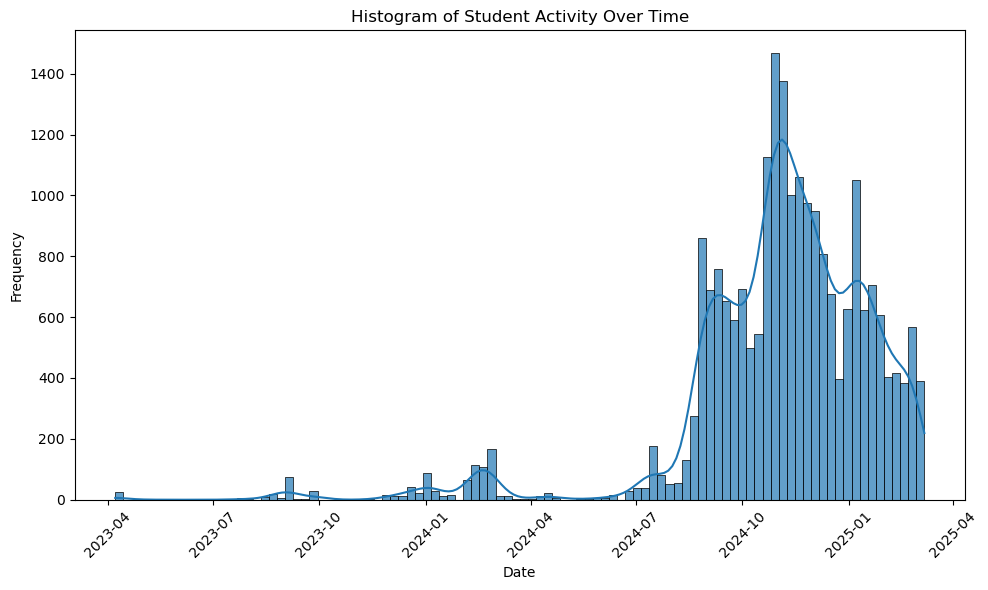

Number of unique users in 2023: 14
Number of unique users in 2024: 729
Number of unique users in 2025: 414


In [73]:
# Plot a histogram of activity start dates
plt.figure(figsize=(10, 6))
sns.histplot(activity['activity_started'], 
             bins=100, 
             alpha=0.7, 
             kde=True)

plt.title('Histogram of Student Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print number of unique users per year
min_year = activity['activity_started'].dt.year.min()
max_year = activity['activity_started'].dt.year.max()
for year in range(min_year, max_year + 1):
    print(f"Number of unique users in {year}:", activity[activity['activity_started'].dt.year == year]['user_id'].nunique())


**Observation:**

We observe that there were only 14 unique students in early 2023, compared to 729 in 2024, and 414 in 2025. Additionally, a few outliers appear in early 2023 that should be excluded from the analysis.

Interestingly, the right side of the distribution reveals a clear pattern with three noticeable peaks, indicating periods of significantly higher activity compared to the initial phase.

After testing various time segmentations, we ultimately selected the periods shown in the following figure.

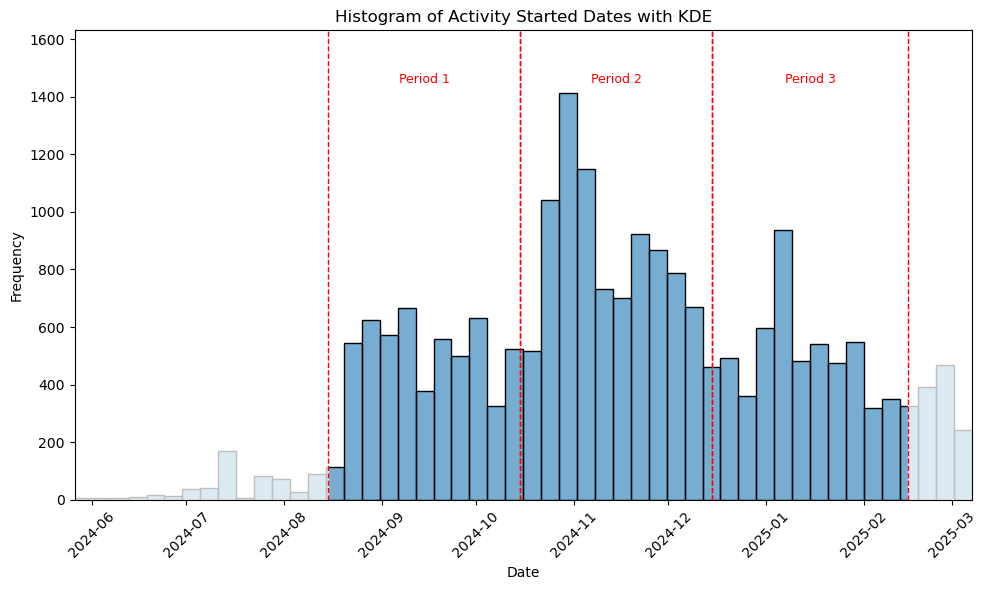

Number of unique users in Period 1: 427
Number of unique users in Period 2: 565
Number of unique users in Period 3: 417


In [81]:
# Remove outliers in activity_started with IQR method only for visualization
Q1 = activity['activity_started'].quantile(0.25)
Q3 = activity['activity_started'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
activity_viz = activity[
    (activity['activity_started'] >= lower_bound) &
    (activity['activity_started'] <= upper_bound)
]

# Define dynamic periods
periods = [
    ('2024-08-15', '2024-10-15', 'Period 1'),
    ('2024-10-15', '2024-12-15', 'Period 2'),
    ('2024-12-15', '2025-02-15', 'Period 3'),
]

# Prepare range
min_date = activity_viz['activity_started'].min()
max_date = activity_viz['activity_started'].max()

# Plot histogram and KDE using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    activity_viz['activity_started'],
    bins=50,
    alpha=0.6,
)

# Convert period boundaries to timestamps
period_bounds = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end, _ in periods]
first_start = period_bounds[0][0]
last_end = period_bounds[-1][1]

# Shade before first and after last period
shade_color, shade_alpha = 'white', 0.75
if min_date < first_start:
    plt.axvspan(min_date, first_start, color=shade_color, alpha=shade_alpha)
if max_date > last_end:
    plt.axvspan(last_end, max_date, color=shade_color, alpha=shade_alpha)

# Add vertical dashed lines and period labels
period_color = 'red'
ymax = plt.gca().get_ylim()[1]
for (start_ts, end_ts), (_, _, period_name) in zip(period_bounds, periods):
    midpoint = start_ts + (end_ts - start_ts) / 2
    plt.axvline(start_ts, color=period_color, linestyle='--', linewidth=1)
    plt.axvline(end_ts, color=period_color, linestyle='--', linewidth=1)
    plt.text(midpoint, ymax, period_name,
             ha='center', va='top', fontsize=9, color=period_color,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Final formatting
plt.title('Histogram of Activity Started Dates with KDE')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlim(min_date, max_date)
plt.ylim(0, ymax * 1.1)  # To give some space above the highest bar
plt.grid(False)
plt.tight_layout()
plt.show()

# Print the number of unique users in each period
for start, end, period_name in periods:
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    unique_users = activity[
        (activity['activity_started'] >= start_date) &
        (activity['activity_started'] <= end_date)
    ]['user_id'].nunique()
    print(f"Number of unique users in {period_name}:", unique_users)

**Approach:**

We deliberately chose not to place the period boundaries exactly at the local minima between peaks in the activity distribution, in order to preserve consistent period lengths.

The selected periods are as follows:

* **Period 1**: August 15, 2024 – October 15, 2024 (427 unique students)
* **Period 2**: October 15, 2024 – December 15, 2024 (565 unique students)
* **Period 3**: December 15, 2024 – February 15, 2025 (417 unique students)

While these periods do not align with conventional timeframes such as seasons or academic terms, they each span exactly two months and include a comparable number of unique students, allowing for meaningful analysis of changes over time.

We believe that defining periods should be a data-driven process tailored to the specific characteristics of the dataset, rather than relying on fixed calendar windows that may not yield relevant insights.

For conciseness, we will refer to these periods as *Period i* throughout the notebook, rather than repeatedly mentioning the corresponding dates.

### C) Student Dataframe by Time Period

We will now create the student dataframes for each time period. These will be similar to the one used in M4, but with the addition of a temporal dimension.

In [ ]:
def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.
    """
    user_activity_periods = {}

    for start_date, end_date, period_name in periods:
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) &
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)

        if period_activity.empty:
            continue

        user_daily_activity = period_activity.copy()
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        duration_median = (period_activity['activity_completed'] - period_activity['activity_started']).groupby(period_activity['user_id']).median()

        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        user_activity['period'] = period_name

        user_activity_periods[period_name] = user_activity

    return user_activity_periods

# Create the period user activity dict
user_activity_periods = create_user_activity_by_period(activity, periods)

# Concatenate all into one dataframe
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nUser activity across all periods:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")


User activity across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,128,NaN,1,6,2,1.525000,Period 1
1,129,NaN,1,1,1,1.850000,Period 1
2,130,NaN,1,66,4,0.375000,Period 1
3,131,NaN,1,11,2,0.600000,Period 1
4,142,NaN,1,9,2,6.483333,Period 1


Shape: (1409, 7)


Let’s now visualize the number of students in each period and how their retention evolves over time.

In [123]:
def plot_student_retention_sankey():
    """
    Plot a Sankey diagram showing student retention over time.
    """
    # Count unique users in each period
    user_counts = {}
    for period_name, user_activity in user_activity_periods.items():
        unique_users = user_activity['user_id'].nunique()
        user_counts[period_name] = unique_users

    # Continous periods pairs
    period_pairs = []
    for i in range(len(periods) - 1):
        period1 = periods[i][2]
        period2 = periods[i + 1][2]
        period_pairs.append((period1, period2))

    # Count common users in each pair of continuous periods
    common_users = {}
    for period1, period2 in period_pairs:
        users_period1 = user_activity_periods[period1]['user_id'].unique()
        users_period2 = user_activity_periods[period2]['user_id'].unique()
        common_count = len(set(users_period1) & set(users_period2))
        common_users[(period1, period2)] = common_count

    period_names = [p for _, _, p in periods]
    num_periods = len(period_names)

    label_list, label_index = [], {}
    node_colors, node_x, node_y = [], [], []

    # Main period nodes
    for i, period in enumerate(period_names):
        label = f"{user_counts[period]} students"
        label_index[period] = len(label_list)
        label_list.append(label)
        node_colors.append("#4c72b0")
        node_x.append(i / (num_periods - 1))
        node_y.append(0.1)

    # Dropout nodes
    for i, period in enumerate(period_names[:-1]):
        nb_dropout = user_counts[period] - common_users[(period, period_names[i + 1])]
        label = f"{nb_dropout} dropped"
        label_index[f"{period}_dropout"] = len(label_list)
        label_list.append(label)
        node_colors.append("#d62728")
        node_x.append((i + 1) / (num_periods - 1))
        node_y.append(0.7)

    # Hidden new joiner nodes
    for i, period in enumerate(period_names[1:], start=1):
        label_index[f"{period}_new"] = len(label_list)
        label_list.append("")  # hidden label
        node_colors.append("rgba(0,0,0,0)")
        node_x.append(i / (num_periods - 1))
        node_y.append(1.0)

    # Link setup
    sources, targets, values = [], [], []
    link_colors, link_labels = [], []

    for i in range(num_periods - 1):
        p1, p2 = period_names[i], period_names[i + 1]
        total_p1 = user_counts[p1]
        total_p2 = user_counts[p2]
        common = common_users[(p1, p2)]
        dropout = total_p1 - common
        new_joiners = total_p2 - common

        # Continuing users
        sources.append(label_index[p1])
        targets.append(label_index[p2])
        values.append(common)
        link_colors.append("rgba(100,149,237,0.5)")
        link_labels.append(f"{common} continuing")

        # Dropouts
        sources.append(label_index[p1])
        targets.append(label_index[f"{p1}_dropout"])
        values.append(dropout)
        link_colors.append("rgba(220,20,60,0.3)")
        link_labels.append(f"{dropout} dropped")

        # New joiners (hidden source)
        sources.append(label_index[f"{p2}_new"])
        targets.append(label_index[p2])
        values.append(new_joiners)
        link_colors.append("rgba(0,0,0,0)")
        link_labels.append("")

    # Plot Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=30,
            line=dict(color="rgba(0,0,0,0)", width=0),
            label=label_list,
            color=node_colors,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            label=link_labels
        )
    )])

    # Add period labels at the bottom
    annotations = []
    for i, period in enumerate(period_names):
        annotations.append(dict(
            x=i / (num_periods - 1),
            y=0,
            text=period,
            showarrow=False,
            xanchor='center',
            yanchor='top',
            font=dict(size=10)
        ))

    fig.update_layout(
        title_text="Student Retention Over Time",
        title_x=0.5,
        title_y=0.95,
        font_size=10,
        margin=dict(l=40, r=40, t=130, b=40),
        annotations=annotations
    )

    fig.show()

    print("Unique users in each period:")
    for period_name, count in user_counts.items():
        print(f"- {period_name}: {count}")
    print()
    print("Common users in each pair of continuous periods:")
    for (period1, period2), count in common_users.items():
        print(f"- {period1} -> {period2}: {count}")

plot_student_retention_sankey()

Unique users in each period:
- Period 1: 427
- Period 2: 565
- Period 3: 417

Common users in each pair of continuous periods:
- Period 1 -> Period 2: 314
- Period 2 -> Period 3: 310


**Observations:**

We observe that the periods have a comparable number of unique students (P1: 427, P2: 565, and P3: 417), and the number of students shared between consecutive periods is also very similar (P1 -> P2: 314 and P2 -> P3: 310).

While we will later apply normalization techniques, the already balanced student counts and overlaps across periods provide a solid foundation for meaningful comparisons and help reduce bias from sample size fluctuations.

TODO: Add merge with scores

##### 2) Student Feature Creation:

We will now compute a set of features for each student to enable clustering and identify different profiles. The final dataframe should contain one row per student, with columns summarizing their activity.

In [5]:
user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Compute the median of gap_days per user
user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median()
).reset_index(drop=True)

# Add the number of activities of that user (count)
user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

# Drop the original timedelta column
user_activity.drop(columns=['median_activity_duration'], inplace=True)

print("Activity per User:")
display(user_activity.head())
print("Shape:", user_activity.shape)


Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_78587/2776266635.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


We now have our `user_activity` (input) dataframe, where each row corresponds to a student and includes their activity features. Their descriptions and distributions will be discussed later in Task 1.C.

### B) Student Scores (Target):

**Approach:**

We will begin by loading the `all_scores` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)
- Aggregate the scores for each student by computing the median of their scores
- Remove outliers

In [6]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

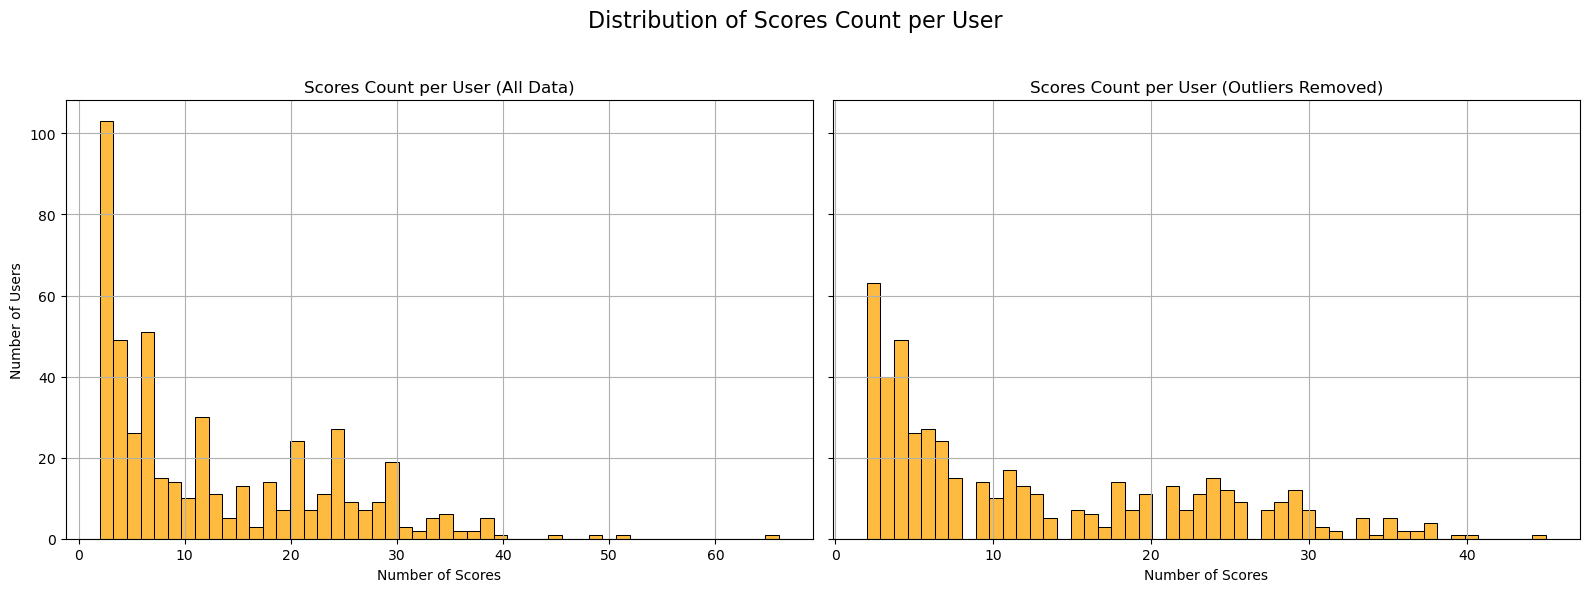

Number of users before outlier removal: 494
Number of users after outlier removal: 491 (99.39%)


In [7]:
# Compute median and count of scores per user
students_median_score = all_scores.groupby('user_id')['percentage'].median().reset_index()
students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
students_median_score['scores_count'] = all_scores.groupby('user_id')['percentage'].count().values

# Remove users with less than 1 score
students_median_score = students_median_score[students_median_score['scores_count'] > 1]

# Plot 1: Original distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[0], color='orange')
axes[0].set_title('Scores Count per User (All Data)')
axes[0].set_xlabel('Number of Scores')
axes[0].set_ylabel('Number of Users')
axes[0].grid()

# IQR Outlier Removal (in-place on df)
Q1 = students_median_score['scores_count'].quantile(0.25)
Q3 = students_median_score['scores_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter in-place
length_before = len(students_median_score)
students_median_score = students_median_score[(students_median_score['scores_count'] >= lower_bound) & (students_median_score['scores_count'] <= upper_bound)]
length_after = len(students_median_score)

# Plot 2: After outlier removal
sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[1], color='orange')
axes[1].set_title('Scores Count per User (Outliers Removed)')
axes[1].set_xlabel('Number of Scores')
axes[1].grid()

plt.suptitle('Distribution of Scores Count per User', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Number of users before outlier removal: {length_before}")
print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

Once again, we removed outlier students (those with very few or very many entries) using the IQR method. This helps eliminate bias from users who participated only once, as well as those who were unusually active and not representative of the majority. In both cases, the distributions are right-skewed.

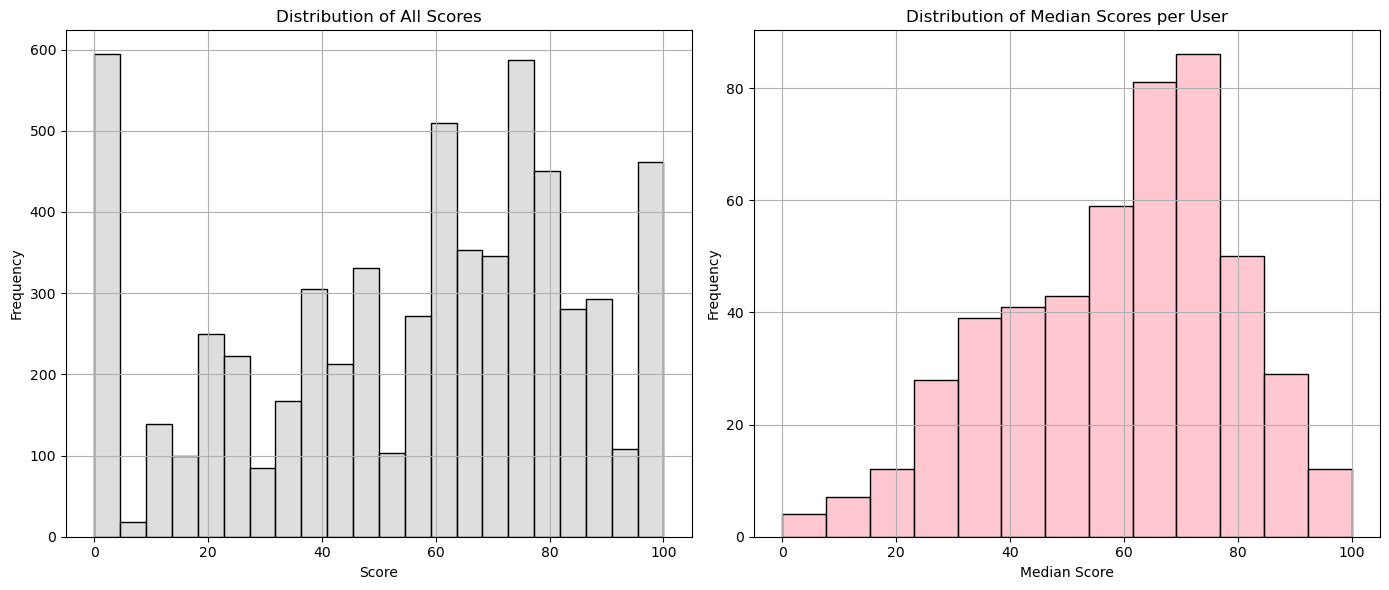

In [8]:
# Apply the outlier removal to the all_scores dataframe
all_scores = all_scores[all_scores['user_id'].isin(students_median_score['user_id'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution of all individual scores
sns.histplot(all_scores['percentage'], color='lightgrey', ax=axes[0])
axes[0].set_title('Distribution of All Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Right: Distribution of median scores per user
sns.histplot(students_median_score['median_score'], color='lightpink', ax=axes[1])
axes[1].set_title('Distribution of Median Scores per User')
axes[1].set_xlabel('Median Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:**

The chart on the left shows the distribution of all individual scores. We observe a noisy Gaussian-like distribution with two unusual peaks at 0 and 100. One possible explanation is that the scores are expressed as percentages, and exercises graded out of 1 point can result only in 0% or 100%.

On the right, we see the distribution of each student's median score, which follows a normal distribution centered around 75%. Notably, the sharp peaks at 0 and 100 disappear after aggregating by student. This is likely due to the use of the median, which is less sensitive to outliers than the mean.

From this point onward, we will consider only the median score per user (i.e., the overall user grade), as shown in the chart on the right.

### C) All-in-All (Inputs + Target)

In [9]:
# Create a final dataframe with user activity and scores
students = user_activity.merge(
    students_median_score,
    how='inner',
    left_on='user_id',
    right_on='user_id'
)

# Print number of users
print(f"Number of users in user_activity: {user_activity['user_id'].nunique()}")
print(f"Number of users in students_median_score: {students_median_score['user_id'].nunique()}")
print(f"Number of users after merging: {students['user_id'].nunique()}")

display(students.head())

Number of users in user_activity: 843
Number of users in students_median_score: 491
Number of users after merging: 472


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,median_score,scores_count
0,1,4.0,11,19,2,4.716667,59.147059,2
1,4,7.5,7,31,1,2.266667,71.000000,3
2,6,7.0,9,30,2,7.658333,57.275000,14
3,7,4.0,16,30,2,13.583333,74.000000,5
4,9,12.0,8,26,2,6.466667,50.000000,5


We end up with a final `students` dataset containing 472 students, which closely matches the size of the scores dataset (96% overlap). Let's visualize the distribution of each feature.

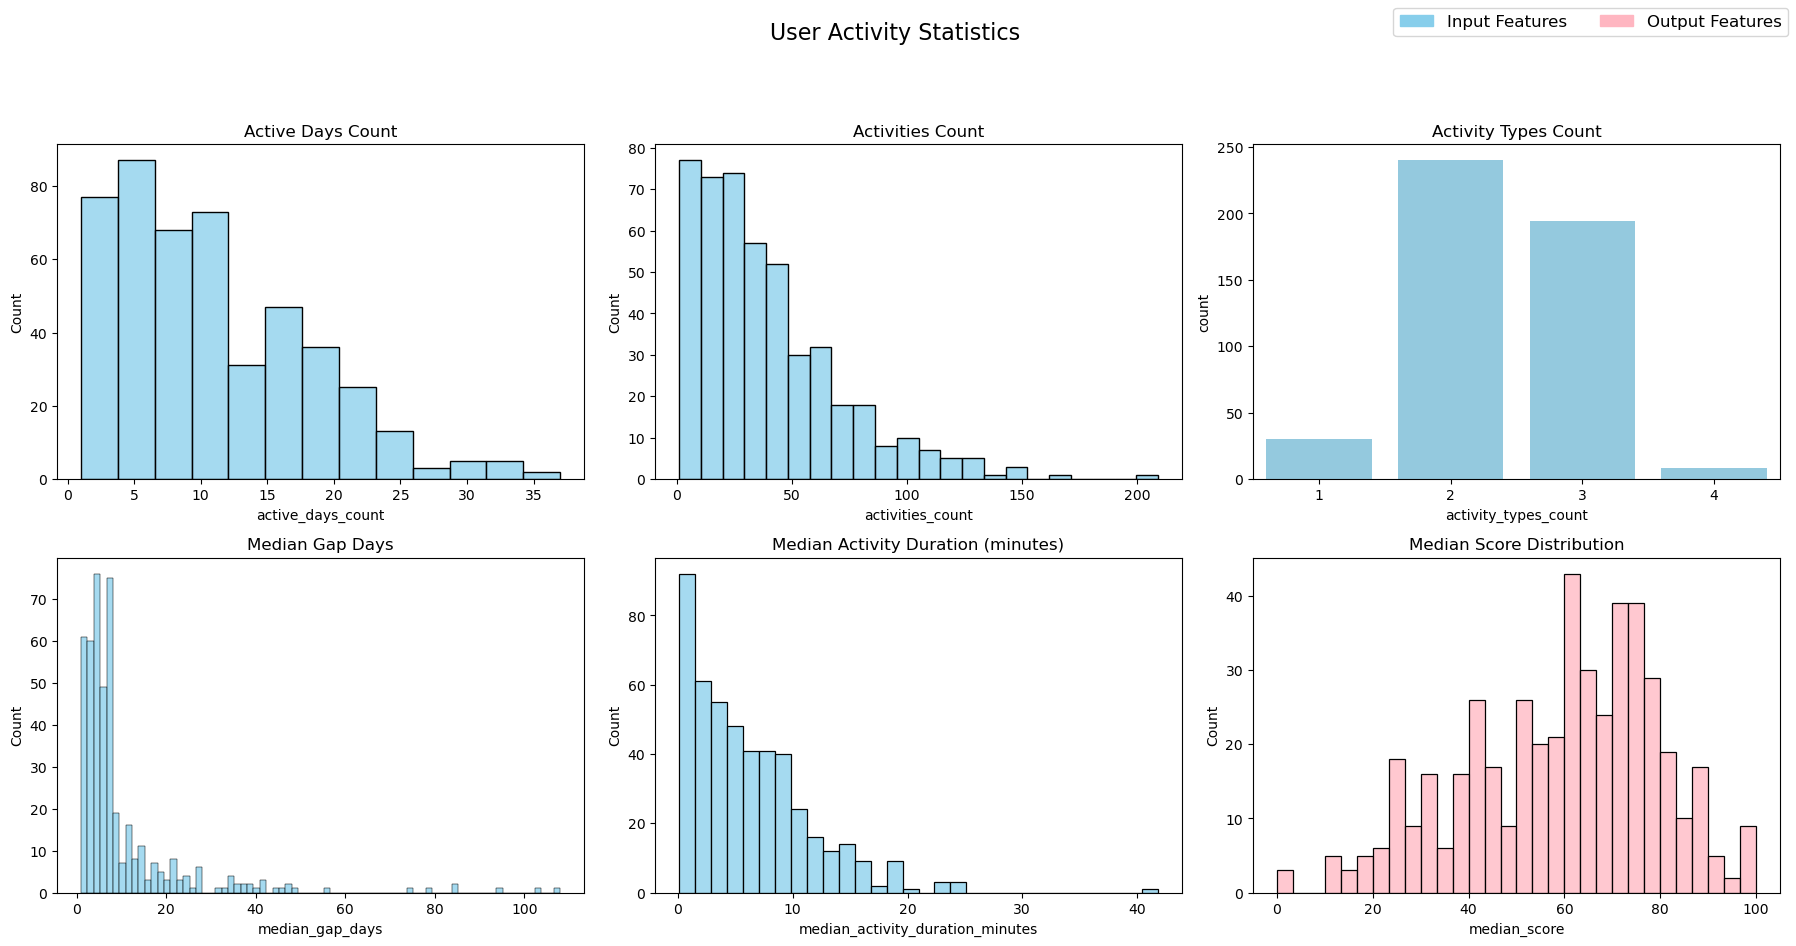

In [ ]:
# Plot each column in a suitable seaborn chart using a single figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("User Activity Statistics", fontsize=16)

# Histogram for active_days_count
sns.histplot(students['active_days_count'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Active Days Count')

# Histogram for activities_count
sns.histplot(students['activities_count'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Activities Count')

# Countplot for activity_types_count
sns.countplot(x=students['activity_types_count'], ax=axes[0, 2], color='skyblue')
axes[0, 2].set_title('Activity Types Count')

# Histogram for median_gap_days
sns.histplot(students['median_gap_days'], ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Median Gap Days')

# Histogram for median_activity_duration_minutes
sns.histplot(students['median_activity_duration_minutes'], ax=axes[1, 1], bins=30, color='skyblue')
axes[1, 1].set_title('Median Activity Duration (minutes)')

# Histogram for median_score
sns.histplot(students['median_score'], ax=axes[1, 2], bins=30, color='lightpink')
axes[1, 2].set_title('Median Score Distribution')

# Add legend
input_patch = Patch(color='skyblue', label='Input Features')
target_patch = Patch(color='lightpink', label='Target Features')
fig.legend(handles=[input_patch, target_patch], loc='upper right', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()

**Students Clustering Features (Inputs):**

- `user_id`: The unique identifier of the student.
- `active_days_count`: The number of days the student has been active since registering.  
- `activities_count`: The total number of activities the student has completed since registration. _Right-skewed distribution, likely an exponential distribution._
- `activity_types_count`: The number of distinct activity types the student has engaged in since registration, indicating whether they focus on a few types or use the app for various learning purposes. _Gaussian distribution_
- `median_gap_days`: The median number of days between consecutive login days for the student. _Right-skewed distribution, likely an exponential distribution._
- `median_activity_duration_minutes`: The median duration, in minutes, of the student's activities. _Right-skewed distribution, likely an exponential distribution._

**Students Score (Target):**
- `median_score`: The median of all the scores the student has received. _Gaussian distribution_


## Task 2: Model Building

Train a model for your research question. 

### A) Profiles Creation (Student Clustering):

We will create clusters of students to better understand the different learner profiles. To achieve this, we will use an unsupervised learning approach with K-Means clustering.

The key hyperparameters we will determine are:

- **Features used for clustering:** Determined through correlation analysis and machine learning coefficient interpretation.
- **Number of clusters (K):** Determined using the Elbow method  

##### 1) Hyperparameter Tuning of Clustering Features:

**Approach:**

- **Corralation Analysis:** As observed in Task A.C, the scores follow a Gaussian distribution. However, the input features are highly right-skewed and appear to follow an exponential distribution. Therefore, we will use Spearman correlation instead of Pearson, as the latter is only appropriate for normally distributed data.

- **Machine Learning Coefficient Interpretation:** We will use a linear regression model to interpret the coefficients and understand which features are most strongly associated with the target. Since the goal is interpretation rather than prediction, we will train the model on the full dataset without splitting it into training and evaluation sets. However, to ensure robustness, we will perform cross-validation and average the coefficient weights across folds.

In [11]:
# Define the candidate features for clustering
candidate_features = [
    'median_gap_days',
    'active_days_count',
    'activities_count',
    'activity_types_count',
    'median_activity_duration_minutes'
]

# Define the target variable
target = 'median_score'

# Drop entries with missing values in the candidate features and target (necessary for models)
students_no_nan = students.dropna(subset=candidate_features + [target], inplace=False)

# Print number of entries after dropping NaN values, and percentage of entries kept
print(f"Number of entries after dropping NaN values: {students_no_nan.shape[0]}")
print(f"Percentage of entries kept: {students_no_nan.shape[0] / students.shape[0] * 100:.2f}%")

Number of entries after dropping NaN values: 451
Percentage of entries kept: 95.55%


In [12]:
# Approach 1: Spearman correlation
correlations = []
p_values = []
for feature in candidate_features:
    data_pair = students_no_nan[[feature, target]]
    corr, p_val = spearmanr(data_pair[feature], data_pair[target])
    correlations.append(corr)
    p_values.append(p_val)

In [13]:
# Approach 2: Linear regression coefficients
X = students_no_nan[candidate_features]
y = students_no_nan[target]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model (defined once)
model = LinearRegression()

# Store per-fold results
all_coefs = []
r2_scores = []
mae_scores = []
rmse_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    all_coefs.append(model.coef_)
    
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Final outputs
weights = np.mean(all_coefs, axis=0)


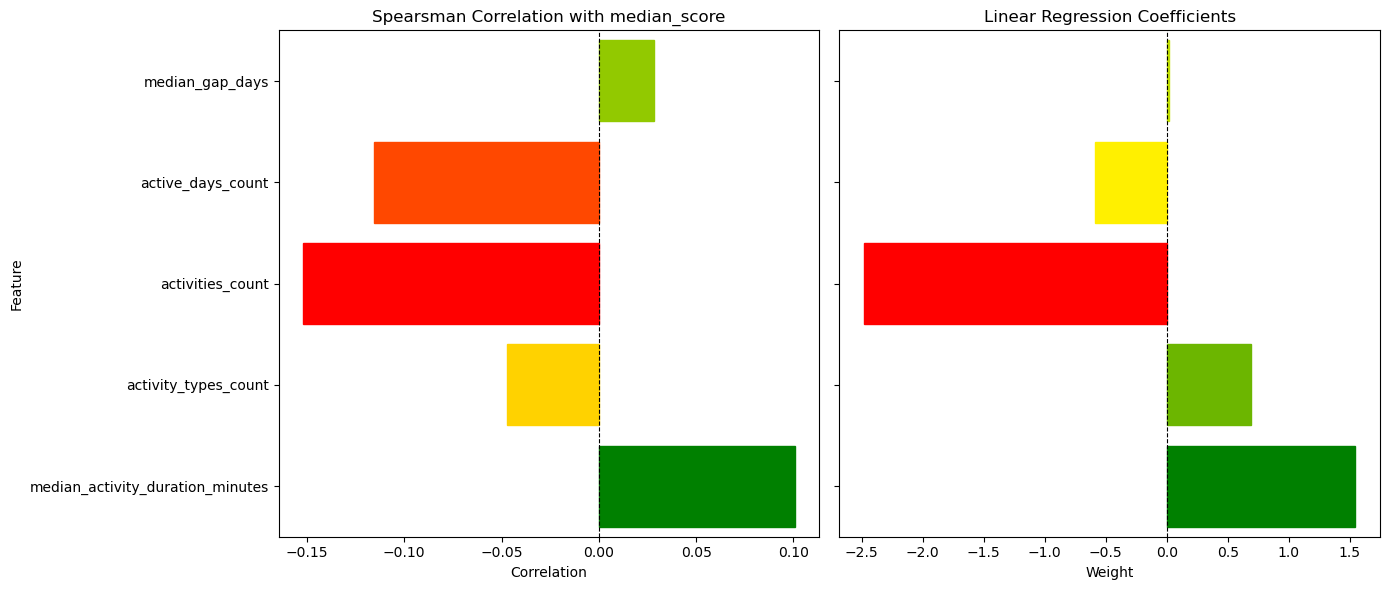

In [14]:
# Combine into DataFrame
combined_df = pd.DataFrame({
    'feature': candidate_features,
    'spearsman_correlation': correlations,
    'linear_regression_coeff': weights
})

# Custom red-to-green gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_red_green", ["red", "yellow", "green"])
norm_corr = Normalize(vmin=min(correlations), vmax=max(correlations))
norm_weight = Normalize(vmin=min(weights), vmax=max(weights))

# Handle colors
corr_colors = [custom_cmap(norm_corr(val)) for val in correlations]
weight_colors = [custom_cmap(norm_weight(val)) for val in weights]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Correlation barplot
bars_corr = sns.barplot(x='spearsman_correlation', y='feature', data=combined_df, ax=axes[0], color='gray')
for bar, color in zip(bars_corr.patches, corr_colors):
    bar.set_color(color)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Spearsman Correlation with median_score')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Feature')

# Linear regression barplot
bars_weight = sns.barplot(x='linear_regression_coeff', y='feature', data=combined_df, ax=axes[1], color='gray')
for bar, color in zip(bars_weight.patches, weight_colors):
    bar.set_color(color)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Linear Regression Coefficients')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


**Observation:**

Overall, the Spearman correlation analysis and the linear regression coefficients show consistent patterns across most features. For instance, both methods indicate a strong negative relationship between `activities_count` and the median score, and a positive association between `median_activity_duration_minutes` and the score. This suggests that longer activity sessions are generally linked with better performance, while simply doing a high number of activities is correlated with lower scores.

However, there are some counterintuitive findings. One example is `median_gap_days`, which shows a slightly positive correlation with the score in the Spearman analysis. This is surprising, as better scores are usually expected to be associated with more frequent (i.e., less spaced out) learning sessions.

**Conclusion:**

This analysis was intended to guide the selection of input features for clustering. However, given the presence of some unexpected relationships, we decided to **retain all features** and evaluate their impact on clustering performance in a later step.

##### 2) Hyperparameter Tuning of Number of Clusters (K):

**Approach:**

We will use K-Means clustering and determine the optimal number of clusters using the Elbow method. The Euclidean distance metric will be used, as it is well-suited for our data, where all features are numerical.

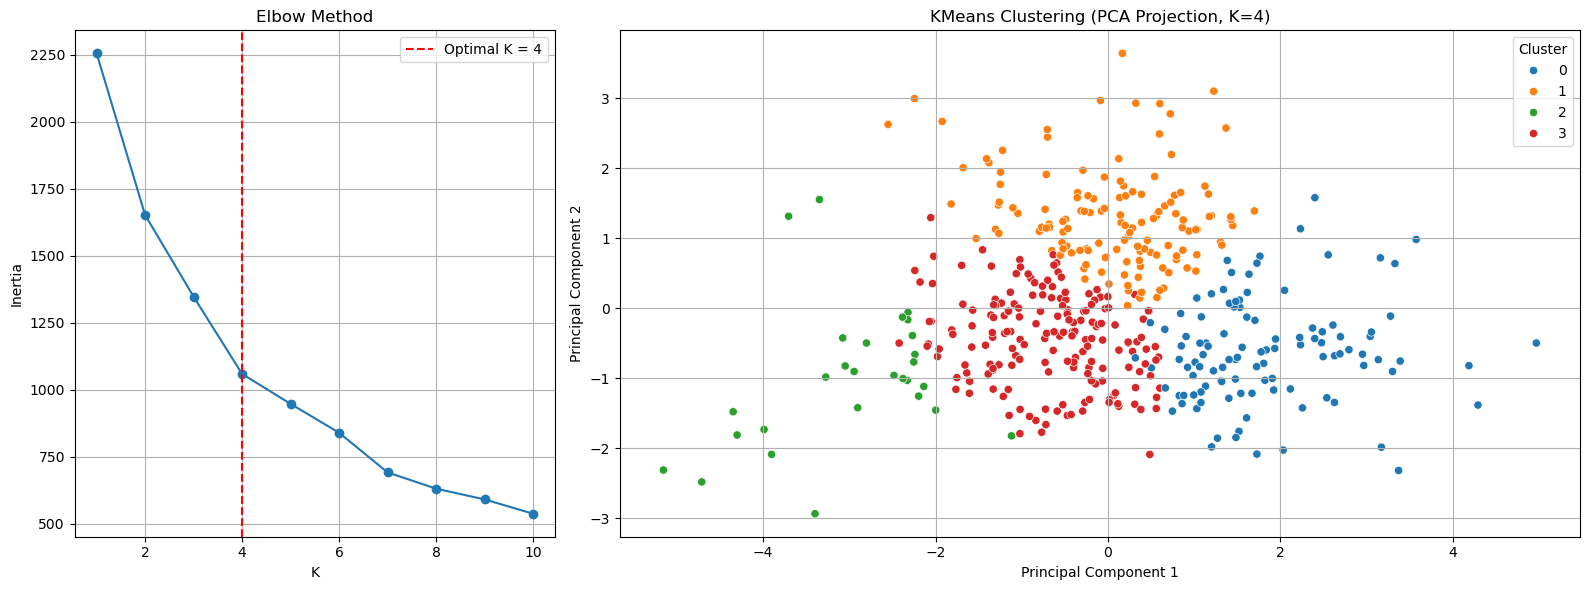

In [15]:
# Use all features for clustering
columns_used = candidate_features
X = students_no_nan[columns_used]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Elbow method to find optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Select optimal K
knee = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee.knee

# Apply KMeans with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
students_no_nan = students_no_nan.copy()
students_no_nan['cluster'] = kmeans.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Plot Elbow chart
axes[0].plot(K_range, inertia, marker='o')
axes[0].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].legend()
axes[0].grid(True)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame
students_projection_pca = students_no_nan.copy()
students_projection_pca['PCA1'] = X_pca[:, 0]
students_projection_pca['PCA2'] = X_pca[:, 1]

# Plot Cluster scatterplot using PCA components
sns.scatterplot(
    data=students_projection_pca,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title(f"KMeans Clustering (PCA Projection, K={optimal_k})")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Observation:**

As shown in the chart on the left, we applied the Elbow method with K-Means to determine that the optimal number of clusters is **4**.

The chart on the right shows a PCA projection of the data onto two dimensions, with each point colored according to its assigned cluster. It is important to note that the clustering was performed in the original feature space. The 2D PCA projection is used only for visualization.

While this projection helps in visualizing the data structure, the clusters do not appear clearly separated in this 2D space. This suggests that the true cluster boundaries may lie in higher-dimensional space and are not easily distinguishable by eye in two dimensions.

### 3) Profiles Interpretation:

Now that we have our clusters, we will compare student scores across them by analyzing the median grade within each cluster. Specifically, we will compute the median of each feature across all students in each cluster. This aggregation approach helps reduce the impact of outliers and provides a more robust comparison.

Additionally, clusters will be ordered in decreasing order of their median score to facilitate interpretation.

In [16]:
# Median feature values per cluster
cluster_values = students_no_nan.groupby('cluster')[columns_used].median().T

# Compute median score and user count per cluster
cluster_score_raw = students_no_nan.groupby('cluster').agg(
    median_score=('median_score', 'median'),
    users_count=('user_id', 'nunique')
)

# Sort clusters by decreasing median_score
sorted_clusters = cluster_score_raw.sort_values(by='median_score', ascending=False).index.tolist()
cluster_values = cluster_values[sorted_clusters]
cluster_score = cluster_score_raw.loc[sorted_clusters].T
new_columns = [f'Cluster {i+1}' for i in range(len(sorted_clusters))]
cluster_values.columns = new_columns
cluster_score.columns = new_columns

# Combine values + scores
cluster_values_df = pd.concat([cluster_values, cluster_score], axis=0)

# Display numeric summary
display(cluster_values_df)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
median_gap_days,41.500000,7.000000,6.000000,4.000000
active_days_count,3.000000,6.000000,14.000000,17.000000
activities_count,9.500000,21.500000,36.000000,79.500000
activity_types_count,2.000000,2.000000,2.000000,3.000000
median_activity_duration_minutes,3.825000,3.679167,11.016667,2.729167
median_score,72.382353,63.432206,62.500000,57.320000
users_count,28.000000,180.000000,135.000000,108.000000


**Interpretation and Visualization Approach:**

The features will be interpreted using simple, color-coded labels for easier readability. Users will be divided into three equally sized groups (low, medium, high) based on how their feature values compare to others.

In [17]:
feature_display_names = {
    'median_gap_days': 'Usage Frequency',
    'active_days_count': 'Total Active Days',
    'activities_count': 'Total Activities',
    'activity_types_count': 'Activity Types',
    'median_activity_duration_minutes': 'Activity Duration',
    'median_score': 'Median Score',
    'users_count': 'Number of Students'
}

def create_interpretation_df(use_auto_colors, interpretation_labels, feature_to_corr=None, custom_cmap=None):
    # Rename cluster columns to "Profile {n+1}"
    profile_values = cluster_values.copy()
    profile_values.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in profile_values.columns]
    
    interpretation_df = pd.DataFrame(index=profile_values.index, columns=profile_values.columns, dtype=object)

    for feature in interpretation_df.index:
        data = students_no_nan[feature]
        values = profile_values.loc[feature]

        if feature == 'median_gap_days':
            data = -data
            values = -values

        _, bins = pd.qcut(data, q=3, retbins=True, duplicates='drop')
        labels = interpretation_labels.get(feature, ['Low', 'Medium', 'High'])[:len(bins) - 1]

        for profile in profile_values.columns:
            bin_index = pd.cut([values[profile]], bins=bins, labels=range(len(labels)), include_lowest=True)[0]
            label_text = labels[int(bin_index)]

            if use_auto_colors:
                corr = feature_to_corr.get(feature, 0)
                if corr >= 0:
                    color = custom_cmap(int(bin_index) / 2)
                else:
                    reversed_bin = 2 - int(bin_index)
                    color = custom_cmap(reversed_bin / 2)
            else:
                color_map = {'Red': 'red', 'Yellow': 'orange', 'Green': 'green'}
                label_text, label_color = interpretation_labels[feature][int(bin_index)]
                color = color_map[label_color]

            interpretation_df.loc[feature, profile] = (label_text, color)

    interpretation_df.loc['median_score'] = [(f"{val:.1f}", None) for val in median_score_row]
    interpretation_df.loc['users_count'] = [(f"{int(val)}", None) for val in users_count_row]
    interpretation_df.index = interpretation_df.index.map(lambda f: feature_display_names.get(f, f))

    return interpretation_df

def plot_interpretation_table(ax, interpretation_df, title):
    sorted_profiles = median_score_row[interpretation_df.columns].sort_values(ascending=False).index.tolist()
    ordered_df = interpretation_df[sorted_profiles]
    student_counts = interpretation_df.loc["Number of Students"]
    student_counts = student_counts[sorted_profiles]
    col_headers = [f"Profile {i+1}\n({int(float(student_counts[col][0]))} students)" for i, col in enumerate(sorted_profiles)]

    display_df = ordered_df.drop(index="Number of Students")
    color_df = ordered_df.drop(index="Number of Students")
    display_df = display_df.map(lambda x: x[0] if isinstance(x, tuple) else x)

    ax.axis('off')
    table = ax.table(
        cellText=display_df.values,
        rowLabels=display_df.index,
        colLabels=col_headers,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_height(0.18)
            continue
        row_label = display_df.index[row - 1]
        if row_label == "Median Score":
            cell.get_text().set_fontweight('bold')
            cell.get_text().set_color('black')
            continue
        value = color_df.iloc[row - 1, col]
        if isinstance(value, tuple) and value[1] is not None:
            cell.get_text().set_color(value[1])

    median_index = display_df.index.get_loc("Median Score") + 1
    row_label_cell = table[(median_index, -1)]
    row_label_cell.get_text().set_fontweight('bold')
    row_label_cell.get_text().set_color('black')

    for row in range(1, len(display_df.index) + 1):
        label_cell = table[(row, -1)]
        label_cell.get_text().set_color('black')

    ax.set_title(title)

# Setup
custom_cmap = LinearSegmentedColormap.from_list("custom_red_orange_green", ["red", "orange", "green"])
feature_to_corr = dict(zip(candidate_features, correlations))

# Manual interpretation labels
manual_labels = {
    'median_gap_days': [('Rarely', 'Red'), ('Occasionally', 'Yellow'), ('Frequently', 'Green')],
    'active_days_count': [('Low Activity', 'Red'), ('Moderate Activity', 'Yellow'), ('High Activity', 'Green')],
    'activities_count': [('Few Activities', 'Red'), ('Some Activities', 'Yellow'), ('Many Activities', 'Green')],
    'median_activity_duration_minutes': [('Short Duration', 'Red'), ('Moderate Duration', 'Yellow'), ('Long Duration', 'Green')],
    'activity_types_count': [('Narrow Focus', 'Red'), ('Moderate Variety', 'Yellow'), ('Diverse Activity', 'Green')],
}

# Auto interpretation labels
auto_labels = {
    'median_gap_days': ['Rarely', 'Occasionally', 'Frequently'],
    'active_days_count': ['Low Activity', 'Moderate Activity', 'High Activity'],
    'activities_count': ['Few Activities', 'Some Activities', 'Many Activities'],
    'median_activity_duration_minutes': ['Short Duration', 'Moderate Duration', 'Long Duration'],
    'activity_types_count': ['Narrow Focus', 'Moderate Variety', 'Diverse Activity'],
}

# Prepare shared cluster_score rows
adjusted_cluster_score = cluster_score.copy()
adjusted_cluster_score.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in adjusted_cluster_score.columns]
median_score_row = adjusted_cluster_score.loc['median_score']
users_count_row = adjusted_cluster_score.loc['users_count']

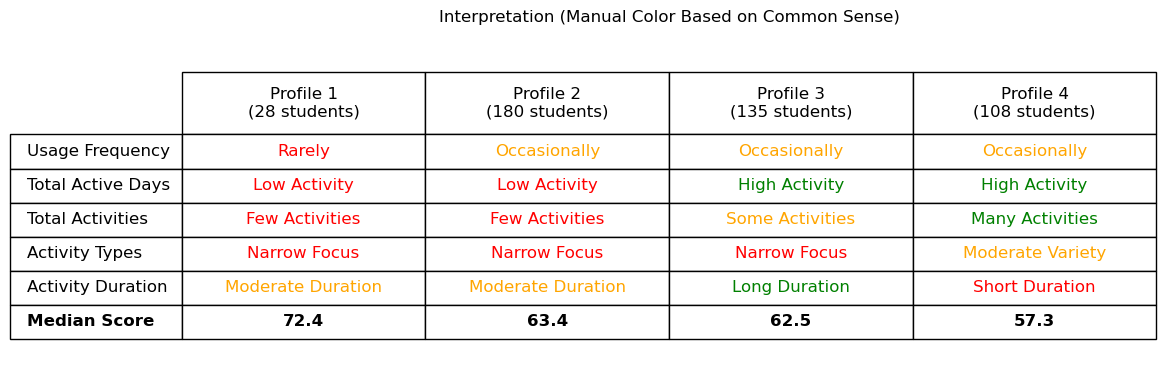

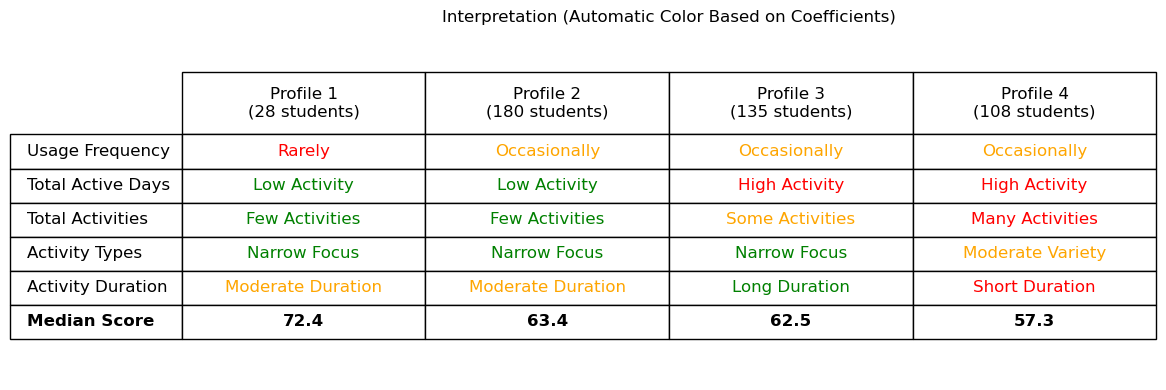

In [18]:
# Create both interpretation DataFrames
manual_df = create_interpretation_df(False, manual_labels)
auto_df = create_interpretation_df(True, auto_labels, feature_to_corr, custom_cmap)

# Plot first table
fig1, ax1 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax1, manual_df, "Interpretation (Manual Color Based on Common Sense)")
plt.tight_layout()
plt.show()

# Plot second table
fig2, ax2 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax2, auto_df, "Interpretation (Automatic Color Based on Coefficients)")
plt.tight_layout()
plt.show()

**Conclusion:**

The four profiles identified through clustering exhibit different learning behaviors and corresponding academic performance, as reflected in their **median scores**.

- **Profile 1 (28 students)**: These students use the app **rarely**, with **low activity**, **few activity types**, and **moderate activity durations**. Despite their limited engagement, they achieve the **highest median score (72.4)**. This suggests that **focused, efficient study sessions** might be particularly effective.

- **Profile 2 (180 students)**: These students also show **low engagement** (few days and activities), with **narrow focus** and **moderate durations**. Their score is slightly lower at **63.4**, indicating a possible difference in study effectiveness compared to Profile 1.

- **Profile 3 (135 students)**: This group is **more active**, with **high usage frequency**, a **broader range of activities**, and **longer durations**, yet their median score is **62.5**. This might suggest that higher activity does not necessarily translate to higher performance, especially if it lacks focus.

- **Profile 4 (108 students)**: These students are also **highly active**, with **many activities** and **moderate variety**, but their **short session durations** are coupled with the **lowest median score (57.3)**. This implies that **short, scattered interactions** may be less effective for learning outcomes.

**Color Coding:**

- **Common Sense**: The top chart uses color coding based on **manual, common-sense interpretations**. For example, "High Activity" is colored green assuming it's a positive sign, and "Rarely" is red as it intuitively seems undesirable.

- **Coefficients**: The bottom chart uses colors derived from the **feature importance coefficients** calculated in Task 2.A.2 (correlation and regression with the median score). This means features are colored based on how much they actually **contribute to performance**.

For example, _Total Active Days_ is colored green in the first table based on the common assumption that being active is beneficial. However, in the second table, it's colored red for some profiles, as the data shows a **negative relationship** between high activity and score.

The comparison reveals that the coefficient-based interpretation better aligns with the actual performance scores. Therefore, we should prioritize the coefficient-based interpretation when assessing what makes a student perform better.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

Our models can be evaluated on two main aspects:

- The reliability of feature weights obtained through Spearman correlation and linear regression coefficients  
- The performance of the clustering produced by K-Means  

We will now evaluate our models and interpret their performance.

### 1) Feature Impact Evaluation:

In [19]:
# Create DataFrame from lists
spearman_df = pd.DataFrame({
    'feature': candidate_features,
    'correlation': correlations,
    'p_value': p_values
})

# Add significance info
spearman_df['significant'] = spearman_df['p_value'] < 0.05
spearman_df['significant'] = spearman_df['significant'].apply(lambda x: '✅' if x else '')

# Format decimal values
spearman_df['correlation'] = spearman_df['correlation'].apply(lambda x: f"{x:.2f}")
spearman_df['p_value'] = spearman_df['p_value'].apply(lambda x: f"{x:.3f}")

# Print final evaluation
print("Spearman Correlation Evaluation:")
print(spearman_df)

Spearman Correlation Evaluation:
                            feature correlation p_value significant
0                   median_gap_days        0.03   0.546            
1                 active_days_count       -0.12   0.014           ✅
2                  activities_count       -0.15   0.001           ✅
3              activity_types_count       -0.05   0.315            
4  median_activity_duration_minutes        0.10   0.033           ✅


**Discussion:**

Spearman analysis reveals that `active_days_count`, `activities_count`, and `median_activity_duration_minutes` have weak but statistically significant monotonic relationships with the target.

In [20]:
print("Linear Regression Evaluation:")
print(f"Average R²:   {np.mean(r2_scores):.3f}")
print(f"Average MAE:  {np.mean(mae_scores):.3f}")
print(f"Average RMSE: {np.mean(rmse_scores):.3f}")

Linear Regression Evaluation:
Average R²:   -0.007
Average MAE:  16.572
Average RMSE: 20.418


**Discussion:**

The linear regression model performs poorly in terms of predictive accuracy (negative R²), but that’s not its primary role here. Instead, it’s used to interpret the direction and relative impact of each feature. Despite its low predictive power, the regression coefficients show a consistent pattern with the Spearman correlations. Moreover, the clusters identified later (when colored by feature values) visually reflect the same trends, reinforcing the overall analysis.

### 2) Clustering Evaluation:

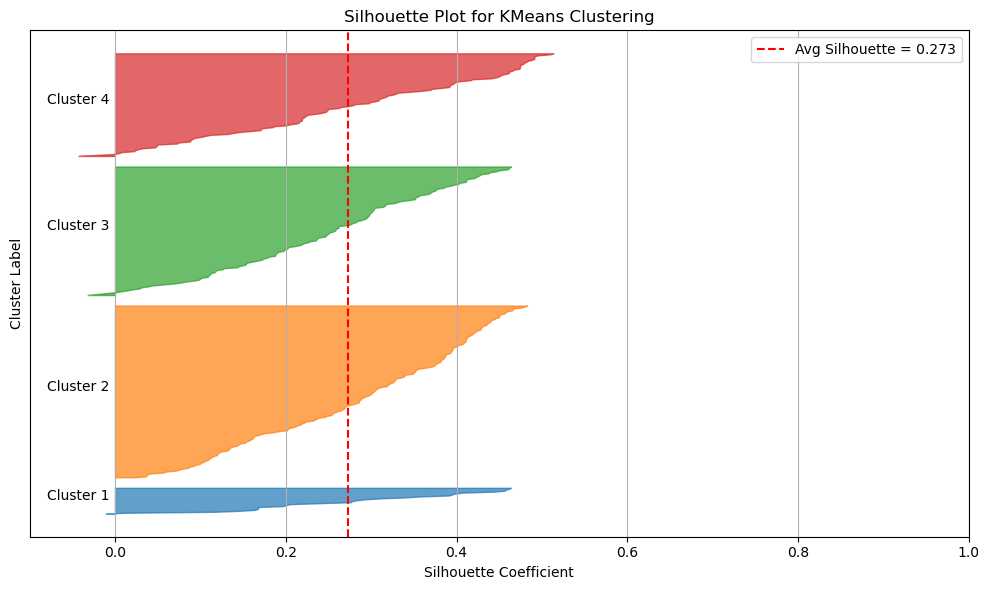

In [21]:
# Compute silhouette values for each sample
silhouette_vals = silhouette_samples(X_scaled, students_no_nan['cluster'])
cluster_labels = students_no_nan['cluster']

# Compute cluster order based on decreasing median_score
cluster_medians = students_no_nan.groupby('cluster')['median_score'].median()
sorted_cluster_ids = cluster_medians.sort_values(ascending=False).index.tolist()

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10  # starting y position

for i, cluster_id in enumerate(sorted_cluster_ids):
    # Get silhouette scores for samples in cluster_id
    ith_cluster_sil_vals = silhouette_vals[cluster_labels == cluster_id]
    ith_cluster_sil_vals.sort()

    size_cluster_i = ith_cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_sil_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax.text(-0.08, y_lower + 0.5 * size_cluster_i, f"Cluster {i+1}")
    y_lower = y_upper + 10  # spacing between clusters

# Average silhouette score line
avg_score = silhouette_score(X_scaled, cluster_labels)
ax.axvline(avg_score, color="red", linestyle="--", label=f"Avg Silhouette = {avg_score:.3f}")

# Labels and formatting
ax.set_title("Silhouette Plot for KMeans Clustering")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


**Discussion:**

The average silhouette score is **0.273**, which, while modest, still reflects some meaningful structure in the data. As noted in Task B.3, Clusters 1 and 2 share similar characteristics, suggesting they could potentially be merged — explaining some of the lower silhouette values.

That said, the modest clustering performance may be attributed to the limited richness of the data or to unclear cluster boundaries. It also reflects the limitations of KMeans, which assumes spherical and equally sized clusters, and of the silhouette score, which may not fully capture more complex or overlapping structures in the data.

Besides the Elbow Method used in our analysis, other techniques such as Silhouette Width could be explored in future work to refine the number of clusters. Silhouette Width was not used for selection here to avoid biasing the interpretation of this plot, which serves as a post-hoc validation of the chosen K.

Nevertheless, the analysis successfully revealed distinct user profiles and allowed us to compare their performance in terms of median scores. This, in turn, provided valuable insights into the factors that may influence academic success, highlighting meaningful patterns and differences across student profiles.

### 3) Method Refinement:

We refined our machine learning approach based on the results we obtained. For instance, in addition to the current version using KMeans clustering, we also experimented with DBSCAN. However, the results were not promising, as DBSCAN produced seven distinct clusters—too many for the scope of our study.

For cluster visualization, we initially used PCA, but also tested alternative dimensionality reduction techniques such as t-SNE and UMAP. While these methods produced more clearly separated blobs, the resulting visual structures did not correspond to actual clusters—meaning the projected shapes had little to do with meaningful groupings in the data.

At one point, we considered projecting the data using t-SNE before applying KMeans, in hopes of generating more insightful visualizations. However, t-SNE is primarily intended for post-clustering visualization and not for preprocessing before clustering. As such, we abandoned this approach.

Lastly, we explored additional feature engineering techniques. Beyond computing the `median_gap_day`, we introduced a categorical feature representing user activity frequency (`single_activity`, `daily`, `weekly`, `monthly`). However, we later discarded this feature, as it was essentially a transformation of `median_gap_day` and did not improve performance.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

For Milestone 4, we all contributed equally. At the beginning, we each explored the data individually to better understand its structure and potential directions. During this phase, we also investigated some additional research questions from Milestone 3 in other notebooks, but these were ultimately omitted from the final notebook to maintain a focused and concise analysis.

We then came together to collaborate on the final version. Throughout the process, we maintained regular communication through two weekly meetings (one in person and one on Zoom), as well as via Telegram and GitHub, which helped us coordinate our work and share updates efficiently. After finalizing the code, we worked together to complete the report.

One thing we could improve for the next milestone is starting with a more hands-on approach. We initially spent a bit too much time on theoretical planning, while most of our progress came once we were actively coding and engaging with the data. Being more iterative from the beginning could help us move more efficiently next time.

Moreover, in the future, using a mind map to track the current pipeline and planned features could help better visualize the overall structure, enhance communication, and monitor progress more effectively.